# Text Summerization - Encoder Decoder with Attention Mechanism

### Importing Basic libraries

In [1]:
!pip install contractions

     |████████████████████████████████| 321 kB 1.2 MB/s 
     |████████████████████████████████| 283 kB 9.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=102899 sha256=0de79784bcafcafb8237bdecc4a6fe090117b6d6116733aacd91928b5d46676c
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [2]:
import re
import os
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import contractions
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K 
from tensorflow.python.keras.layers import Layer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importing Data

In [3]:
#Kaggle
data_path = ['../input/cnn-dailymail/cnn_dailymail_train.csv', '../input/cnn-dailymail/cnn_dailymail_test.csv', '../input/cnn-dailymail/cnn_dailymail_test.csv']
data = pd.concat((pd.read_csv(f, index_col=0, header=0) for f in data_path), ignore_index=True)
data.head()

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [4]:
data

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...
...,...,...
310088,Our young Earth may have collided with a body ...,Oxford scientists say a Mercury-like body stru...
310089,A man facing trial for helping his former love...,Man accused of helping former lover kill woman...
310090,A dozen or more metal implements are arranged ...,Marianne Power tried the tuning fork facial at...
310091,Brook Lopez dominated twin brother Robin with ...,Brooklyn Nets beat the Portland Trail Blazers ...


In [5]:
data.drop_duplicates(subset=['highlights'],inplace=True)
data.reset_index(inplace=True, drop=True)

In [6]:
data

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...
...,...,...
293637,Our young Earth may have collided with a body ...,Oxford scientists say a Mercury-like body stru...
293638,A man facing trial for helping his former love...,Man accused of helping former lover kill woman...
293639,A dozen or more metal implements are arranged ...,Marianne Power tried the tuning fork facial at...
293640,Brook Lopez dominated twin brother Robin with ...,Brooklyn Nets beat the Portland Trail Blazers ...


In [7]:
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    text = ' '.join([contractions.fix(word) for word in text.split(" ")])    
    
    tokens = [w for w in text.split() if not w in stop_words]
    text = " ".join(tokens)
    text = text.replace("'s",'')
    text = text.replace(".",'')
    text = re.sub(r'\(.*\)','',text)
    text = re.sub(r'[^a-zA-Z0-9. ]',' ',text)
    text = re.sub(r'\.','. ',text)
    text = re.sub(r'\s+', ' ', text)
    return text


In [8]:
data['highlights'] = data['highlights'].apply(preprocess)
data['article'] = data['article'].apply(preprocess)
data['highlights'] = data['highlights'].apply(lambda x : '_START_ '+ x + ' _END_')

for i in range(2):
    print('Summary:', data['highlights'][i],'Text:', data['article'][i], sep='\n')
    print()

Summary:
_START_ bishop john folda north dakota taking time diagnosed contracted infection contaminated food italy church members fargo grand forks jamestown could exposed  _END_
Text:
 associated press published 14 11 est 25 october 2013 updated 15 36 est 25 october 2013 bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late september early october state health department issued advisory exposure anyone attended five churches took communion bishop john folda bishop located 

Summary:
_START_ criminal complaint cop used role help cocaine traffickers ralph mata internal affairs lieutenant allegedly helped group get guns also arranged pay two assassins murder plot complaint alleges  _END_
Text:
 decided move forward murder plot mata still received payment setting meetings federal prosecutors said statement complaint also alleges mata used police badge purchase weapons drug traffickers mata according complain

In [9]:
headlines_length = [len(x.split()) for x in data['highlights']]
text_length = [len(x.split()) for x in data['article']]

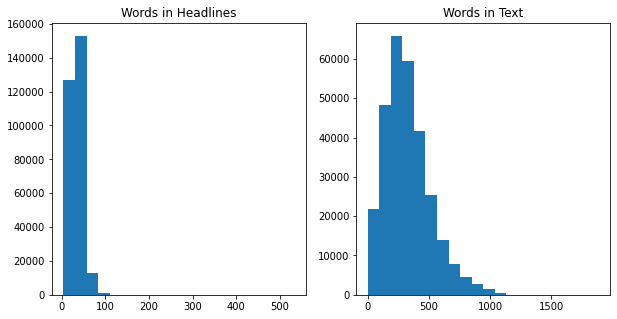

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(headlines_length, bins = 20)
ax2.hist(text_length, bins = 20)

ax1.title.set_text("Words in Headlines")
ax2.title.set_text("Words in Text")
plt.show()

In [11]:
max_length_x = 250
max_length_y = 50
x = []
y = []
for ind in data.index:
    if((len(data.iloc[ind]['article'].split()) <= max_length_x) and (len(data.iloc[ind]['highlights'].split()) <= max_length_y)):
        x.append(data.iloc[ind]['article'])
        y.append(data.iloc[ind]['highlights'])

data = pd.DataFrame(list(zip(x,y)), columns=['article', 'highlights'])
data

,article,highlights
0,associated press published 14 11 est 25 octob...,_START_ bishop john folda north dakota taking ...
1,decided move forward murder plot mata still r...,_START_ criminal complaint cop used role help ...
2,drunk driver killed young woman head on crash ...,_START_ craig eccleston todd 27 drunk least th...
3,accused making many fashion faux pas holiday p...,_START_ prime minister family enjoying easter ...
4,canberra australia campbell unscrews couple bo...,_START_ black box data flight 370 could analyz...
...,...,...
107210,3 000 students facing unexpected decision rece...,_START_ 3 118 applicants accepted freshmen uni...
107211,lydia ko shot 2 over 74 saturday ana inspirati...,_START_ lydia ko shot second straight over par...
107212,backache striking us younger ever almost half ...,_START_ 45 per cent 30s surveyed said painful ...
107213,young earth may collided body similar planet m...,_START_ oxford scientists say mercury like bod...


### Embedding Matrix from Glove


In [12]:
glove_size = 300
f = open('../input/glove42b300dtxt/glove.42B.300d.txt')

In [13]:
embeddings_index = dict()
for line in f:
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
f.close()

In [14]:
words_source_train = []
for i in data['article']:
    words_source_train.extend(i.split(' '))

print("all the words in the corpus", len(words_source_train))
words_source_train = set(words_source_train)
print("the unique words in the corpus", len(words_source_train))
inter_words = set(embeddings_index.keys()).intersection(words_source_train)
print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(words_source_train))
*100)))

words_corpus_source_train = {}
words_glove = set(embeddings_index.keys())
for i in words_source_train:
    if i in words_glove:
        words_corpus_source_train[i] = embeddings_index[i]
print("word 2 vec length", len(words_corpus_source_train))

all the words in the corpus 16855703
the unique words in the corpus 201371
The number of words that are present in both glove vectors and our corpus are 160170 which is nearly 80.0% 
word 2 vec length 160170


In [15]:
print(list(words_source_train - inter_words)[:20])

['', 'tseleevo', 'auwkit', 'steadwood', 'wwwend7org', 'mantach', 'mangerson', 'eakah', 'perbse', 'morocoima', 'furloe', 'scimemi', 'naudel', 'zozu', 'lee10', 'dilawr', 'lovelanekitchencom', 'kamruzzama', 'batoashi', 'courtsiding']


In [16]:
def num(text):
  words = [w for w in text.split() if not w in inter_words]
  return len(words)

data['unique_words'] = data['article'].apply(num)

In [17]:
data['unique_words'].value_counts()

0     60441
1     23249
2     10718
3      5254
4      2838
5      1704
6      1026
7       658
8       444
9       306
10      199
11      128
12       77
13       51
14       36
15       22
17       16
16       10
19        7
18        5
20        5
23        5
21        3
24        3
27        3
26        2
22        1
28        1
29        1
31        1
50        1
Name: unique_words, dtype: int64

In [18]:
data = data[data['unique_words'] < 4]
data.reset_index(inplace=True, drop=True)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data['article'], data['highlights'], test_size = 0.2, random_state = 20)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.7, random_state = 20)

In [21]:
x_t = Tokenizer()
x_t.fit_on_texts(data['article'] + data['highlights'])
x_vocab_size = len(x_t.word_index) + 1

encoded_xtrain = x_t.texts_to_sequences(X_train)
encoded_xval = x_t.texts_to_sequences(X_val)
encoded_xtest = x_t.texts_to_sequences(X_test)

padded_xtrain = pad_sequences(encoded_xtrain, maxlen=max_length_x, padding='post')
padded_xval = pad_sequences(encoded_xval, maxlen=max_length_x, padding='post')
padded_xtest = pad_sequences(encoded_xtest, maxlen=max_length_x, padding='post')

In [22]:
y_t = Tokenizer()
y_t.fit_on_texts(data['highlights'])
y_vocab_size = len(y_t.word_index) + 1

encoded_ytrain = y_t.texts_to_sequences(y_train)
encoded_yval = y_t.texts_to_sequences(y_val)
encoded_ytest = y_t.texts_to_sequences(y_test)

padded_ytrain = pad_sequences(encoded_ytrain, maxlen=max_length_y, padding='post')
padded_yval = pad_sequences(encoded_yval, maxlen=max_length_y, padding='post')
padded_ytest = pad_sequences(encoded_ytest, maxlen=max_length_y, padding='post')

In [23]:
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((x_vocab_size, glove_size))
for word, i in x_t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 1917494 word vectors.


### Building Model

In [24]:
class AttentionLayer(Layer):

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        encoder_out_seq, decoder_out_seq = inputs

        def energy_step(inputs, states):
          
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  
            
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            e_i = K.softmax(e_i)

            return e_i, [e_i]

        def context_step(inputs, states):
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            
            fake_state = K.zeros_like(inputs)  
            fake_state = K.sum(fake_state, axis=[1, 2])  
            fake_state = K.expand_dims(fake_state)  
            fake_state = K.tile(fake_state, [1, hidden_size])  
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  

        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )
        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [25]:
latent_dim=500

K.clear_session() 

encoder_inputs = Input(shape=(max_length_x,)) 
enc_emb = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False)(encoder_inputs) 

#LSTM 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 250, 300)     56277300    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 250, 500), ( 1602000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
checkpoint_filepath = './model.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss',mode='min',save_best_only=True, save_freq = "epoch")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
history=model.fit([padded_xtrain,padded_ytrain[:,:-1]], padded_ytrain.reshape(padded_ytrain.shape[0],padded_ytrain.shape[1], 1)[:,1:] ,epochs=30,batch_size=64, validation_data=([padded_xval,padded_yval[:,:-1]], padded_yval.reshape(padded_yval.shape[0],padded_yval.shape[1], 1)[:,1:]), callbacks=[es, model_checkpoint_callback], verbose=1)

Epoch 1/30
1246/1246 [==============================] - 1061s 842ms/step - loss: 5.4946 - val_loss: 4.7224
Epoch 2/30
1246/1246 [==============================] - 1050s 843ms/step - loss: 4.5734 - val_loss: 4.4202
Epoch 3/30
1246/1246 [==============================] - 1050s 843ms/step - loss: 4.1144 - val_loss: 4.3084
Epoch 4/30
1246/1246 [==============================] - 1052s 844ms/step - loss: 3.7613 - val_loss: 4.2894
Epoch 5/30
1246/1246 [==============================] - 1050s 842ms/step - loss: 3.4822 - val_loss: 4.3015
Epoch 00005: early stopping


In [27]:
# min_val_loss = min(history.history['val_loss'])
# min_epoch = history.history['val_loss'].index(min_val_loss)
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# model.load_weights(f'./model.{min_epoch+1:02d}-{min_val_loss:.2f}.h5')
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

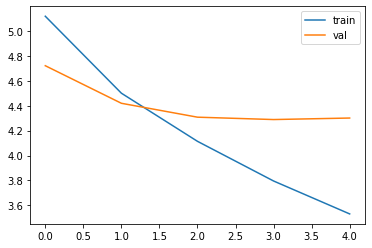

In [28]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='val') 
pyplot.legend() 
pyplot.show()

### Inference

In [29]:
reverse_target_word_index = y_t.index_word 
reverse_source_word_index = x_t.index_word 
target_word_index = y_t.word_index

In [30]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_x,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [31]:
def decode_sequence(input_seq):
    input_seq= input_seq.reshape(1,max_length_x)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
  
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
 
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_length_y-1)):
                stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence

In [32]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [33]:
for i in range(10):
    print("Review:",seq2text(padded_xtest[i]))
    print("Original summary:",seq2summary(padded_ytest[i]))
    print("Predicted summary:",decode_sequence(padded_xtest[i]))
    print("\n")

Review: week losing bubba watson playoff yous masters louis oosthuizen bounced back three shot victory malaysian open sunday oosthuizen 30 hour journey kuala lumpur near miss augusta closed four under par 68 hold challenge scotland stephen gallacher 17 under total 271 gave fifth european tour win oosthuizen acted perfect tonic masters heartbreak it long journey get honest say expect play well tiredness told official european tour website having good week week important playing well want come play bad win means lot playing well last weeks win gives lot confidence rest season oosthuizen play 26 holes final day earlier delays held one shot lead gallacher going last 18 holes gallacher looking second european tour win touch back nine south african opponent birdied 13th 16th pull clear last year masters champion charl schwartzel south african sixth six shots back defending champion matteo manassero former world number one martin kaymer tied seventh 25 million tournament co sanctioned europea

### Evaluation

In [34]:
def BLEU_Score(y_test, y_pred):
    references = [[seq2summary(y_test).split(" ")]]
    candidates = [decode_sequence(y_pred.reshape(1,max_length_x)).split(" ")]
    return corpus_bleu(references, candidates)

In [35]:
from nltk.translate.bleu_score import corpus_bleu
scores=[]
for i in range(len(padded_ytest)):
    try:
        score = BLEU_Score(padded_ytest[i],padded_xtest[i])
        scores.append(score)
    except:
        pass
print(np.mean(scores))

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.38486198634448787


In [38]:
import tensorflow_hub as hub
from scipy import spatial
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
sentence_encoder = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [39]:
def cosine_similarity(padded_xtest, padded_ytest):
    scores = []
    for i in range(len(padded_xtest)):
        try:
            str1 = seq2summary(padded_ytest[i])
            str2 = decode_sequence(padded_xtest[i].reshape(1,max_length_x))
            embeddings = sentence_encoder([str1, str2]).numpy()
            result = 1 - spatial.distance.cosine(embeddings[0], embeddings[1])
            scores.append(result)
        except:
            pass
    return scores

In [40]:
scores = cosine_similarity(padded_xtest, padded_ytest)
np.mean(scores)

0.37166705154858637